# stage2

In [2]:
datadir = 'workspace/competedata_train/'
libdir = 'workspace/'
outputdir = 'workspace/'
otherdir = 'workspace/'
train_bs_ = 16
valid_bs_ = 32
num_workers_ = 8

In [3]:
class CFG:
    seed=42
    device='GPU' #### ['TPU', 'GPU']
    nprocs=1 # [1, 8]
    num_workers=num_workers_
    train_bs=train_bs_
    valid_bs=valid_bs_
    fold_num=5

    target_cols=['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
           'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 
           'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']
    n_class=11
    accum_iter=1
    max_grad_norm=1000
    print_freq=100
    normalize_mean=[0.4824, 0.4824, 0.4824] 
    normalize_std=[0.22, 0.22, 0.22]
    
    suffix="1801" 
    fold_list=[0] 
    epochs=14 
    model_arch="resnet200d" # efficientnet,resnet200d
    img_size=640
    optimizer="Adam"
    scheduler="CosineAnnealingLR"
    loss_fn="BCEWithLogitsLoss"
    scheduler_warmup= None

    teacher= otherdir + "resnet50d_1115_fold0_epoch4_stage1_cv1000.pth"
    weights=[0.5, 1]

    warmup_epo=1
    warmup_factor = 10
    T_max= epochs-warmup_epo-2 if scheduler_warmup=="GradualWarmupSchedulerV2" else \
           epochs-warmup_epo-1 if scheduler_warmup=="GradualWarmupSchedulerV3" else epochs-1 # CosineAnnealingLR
    
    lr=1e-3
    min_lr=1e-6 
    weight_decay=0
    
    fix_mistake = True
    n_early_stopping=3

scheduler: CosineAnnealingLR
scheduler_warmup: None
warmup_epo: 1
warmup_factor: 10
T_max: 13
lr: 0.001
min_lr: 1e-06
weight_decay: 0


In [4]:
import sys; 
if ENV == "kaggle":
    sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
else:
    package_paths = [f'{libdir}pytorch-image-models-master']
    for pth in package_paths:
        sys.path.append(pth)
    

import ast
from glob import glob
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
from tqdm import tqdm
from contextlib import contextmanager
import math

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.model_selection import GroupKFold, StratifiedKFold
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler
import timm
import warnings
import joblib
from scipy.ndimage.interpolation import zoom
if CFG.device == 'TPU':
    !pip install -q pytorch-ignite
    import ignite.distributed as idist
elif CFG.device == 'GPU':
    from torch.cuda.amp import autocast, GradScaler

# helper

In [5]:
train_df = pd.read_csv(f'{datadir}train.csv')
submission_df = pd.read_csv(f'{datadir}sample_submission.csv')
train_annotations_df = pd.read_csv(f'{datadir}train_annotations.csv')

def fix_mistake_label(train_df, train_annotations_df, ann_index, uid, old_label, correct_label):
    train_df.loc[train_df.StudyInstanceUID==uid, old_label] = 0
    train_df.loc[train_df.StudyInstanceUID==uid, correct_label] = 1
    train_annotations_df.loc[train_annotations_df.index==ann_index, 'label'] = correct_label

if CFG.fix_mistake:
    fix_mistake_csv = pd.read_csv(otherdir + "fix_mistake0227.csv")
    for row in fix_mistake_csv.values:
        fix_mistake_label(train_df, train_annotations_df, row[0], row[1], row[2], row[3])
    print("Fix Mistake Done!")

gkf = GroupKFold(n_splits=CFG.fold_num)
folds = gkf.split(train_df, train_df[CFG.target_cols], train_df['PatientID'])

https://ui.neptune.ai/syxuming/ranzcr/e/RAN-319
Fix Mistake Done!


In [6]:
if CFG.device == 'TPU':
    import os
    VERSION = "1.7"
    CP_V = "36" if ENV == "colab" else "37"
    wheel = f"torch_xla-{VERSION}-cp{CP_V}-cp{CP_V}m-linux_x86_64.whl"
    url = f"https://storage.googleapis.com/tpu-pytorch/wheels/{wheel}"
    !pip3 -q install cloud-tpu-client==0.10 $url
    os.system('export XLA_USE_BF16=1')
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    CFG.lr = CFG.lr * CFG.nprocs
    CFG.train_bs = CFG.train_bs // CFG.nprocs
    device = xm.xla_device()
elif CFG.device == "GPU":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 

seed_everything(CFG.seed)


def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=outputdir+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger(outputdir+f'train{CFG.suffix}.log')

if CFG.device=='TPU' and CFG.nprocs==8:
    loginfo = xm.master_print
    cusprint = xm.master_print
else:
    loginfo = LOGGER.info
    cusprint = print

def get_result(result_df):
    preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
    labels = result_df[CFG.target_cols].values
    score, scores = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')


def get_timediff(time1,time2):
    minute_,second_ = divmod(time2-time1,60)
    return f"{int(minute_):02d}:{int(second_):02d}"  


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

                
def freeze_layer(model, cur_epoch, n_frozen_epochs, n_frozen_layers, only_bn): 
    mcnt1 = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            mcnt1 += 1
    ##        
    layer_cnt = 0
    if cur_epoch < n_frozen_epochs:
        sub_model = next(model.children())
        for layer in sub_model.children():
            if only_bn:
                if isinstance(layer, nn.BatchNorm2d):
                    if layer_cnt < n_frozen_layers:
                        layer_cnt += 1
                        for param in layer.parameters():
                            param.requires_grad = False

            else:
                if layer_cnt < n_frozen_layers:
                    layer_cnt += 1
                    for param in layer.parameters():
                        param.requires_grad = False
        if 'efficientnet' in CFG.model_arch:
            classifier_layer = sub_model.classifier.parameters()
        elif 'vit' in CFG.model_arch or 'deit' in CFG.model_arch:
            classifier_layer = sub_model.head.parameters()
        elif 'resnext' in CFG.model_arch:
            classifier_layer = sub_model.fc.parameters()

        for param in classifier_layer:
            param.requires_grad = True
    else:
        for param in model.parameters():
            param.requires_grad = True
    
    ##
    mcnt2 = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            mcnt2 += 1
    print(mcnt1,mcnt2)

In [8]:
COLOR_MAP = {'ETT - Abnormal': (255, 0, 0),
             'ETT - Borderline': (0, 255, 0),
             'ETT - Normal': (0, 0, 255),
             'NGT - Abnormal': (255, 255, 0),
             'NGT - Borderline': (255, 0, 255),
             'NGT - Incompletely Imaged': (0, 255, 255),
             'NGT - Normal': (128, 0, 0),
             'CVC - Abnormal': (0, 128, 0),
             'CVC - Borderline': (0, 0, 128),
             'CVC - Normal': (128, 128, 0),
             'Swan Ganz Catheter Present': (128, 0, 128),
            }

class TrainDataset(Dataset):
    def __init__(self, df, df_annotations, use_annot=False, annot_size=50, transform=None):
        self.df = df
        self.df_annotations = df_annotations
        self.use_annot = use_annot
        self.annot_size = annot_size
        self.file_names = df['StudyInstanceUID'].values
        self.labels = df[CFG.target_cols].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{datadir}train/{file_name}.jpg'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        labels = torch.tensor(self.labels[idx]).float()
        if self.use_annot:
            image_annot = image.copy()
            query_string = f"StudyInstanceUID == '{file_name}'"
            df = self.df_annotations.query(query_string)
            for i, row in df.iterrows():
                label = row["label"]
                data = np.array(ast.literal_eval(row["data"]))
                for d in data:
                    image_annot[d[1]-self.annot_size//2:d[1]+self.annot_size//2,
                          d[0]-self.annot_size//2:d[0]+self.annot_size//2, :] = COLOR_MAP[label]
            if self.transform:
                augmented = self.transform(image=image, image_annot=image_annot)
                image = augmented['image']
                image_annot = augmented['image_annot']
            return image, image_annot, labels
        else:
            if self.transform:
                augmented = self.transform(image=image)
                image = augmented['image']
            return image, labels

In [9]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize, RandomCrop, GaussianBlur, JpegCompression, Downscale, ElasticTransform
)
import albumentations
from albumentations.pytorch import ToTensorV2

def get_transforms(*, data):
    if data == 'train':
        return Compose([
            RandomResizedCrop(CFG.img_size, CFG.img_size, scale=(0.9, 1), p=1), 
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.7),
            RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.7),
            CLAHE(clip_limit=(1,4), p=0.5),
            OneOf([
                OpticalDistortion(distort_limit=1.0),
                GridDistortion(num_steps=5, distort_limit=1.),
                ElasticTransform(alpha=3),
            ], p=0.2),
            OneOf([
                GaussNoise(var_limit=[10, 50]),
                GaussianBlur(),
                MotionBlur(),
                MedianBlur(),
            ], p=0.2),
            Resize(CFG.img_size, CFG.img_size),
            OneOf([
                JpegCompression(),
                Downscale(scale_min=0.1, scale_max=0.15),
            ], p=0.2),
            IAAPiecewiseAffine(p=0.2),
            IAASharpen(p=0.2),
            Cutout(max_h_size=int(CFG.img_size * 0.1), max_w_size=int(CFG.img_size * 0.1), num_holes=5, p=0.5),
            Normalize(mean=CFG.normalize_mean, std=CFG.normalize_std,),
            ToTensorV2(),
            ], additional_targets={'image_annot': 'image'})
        
    elif data == 'light_train':
        return Compose([
            RandomResizedCrop(CFG.img_size, CFG.img_size, scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            RandomBrightnessContrast(p=0.2, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
            HueSaturationValue(p=0.2, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
            ShiftScaleRotate(p=0.2, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
            CoarseDropout(p=0.2),
            Cutout(p=0.2, max_h_size=16, max_w_size=16, fill_value=(0., 0., 0.), num_holes=16),
            Normalize(mean=CFG.normalize_mean, std=CFG.normalize_std,),
            ToTensorV2(),
        ], additional_targets={'image_annot': 'image'})

    elif data == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size),
            Normalize(mean=CFG.normalize_mean, std=CFG.normalize_std,),
            ToTensorV2(),
        ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


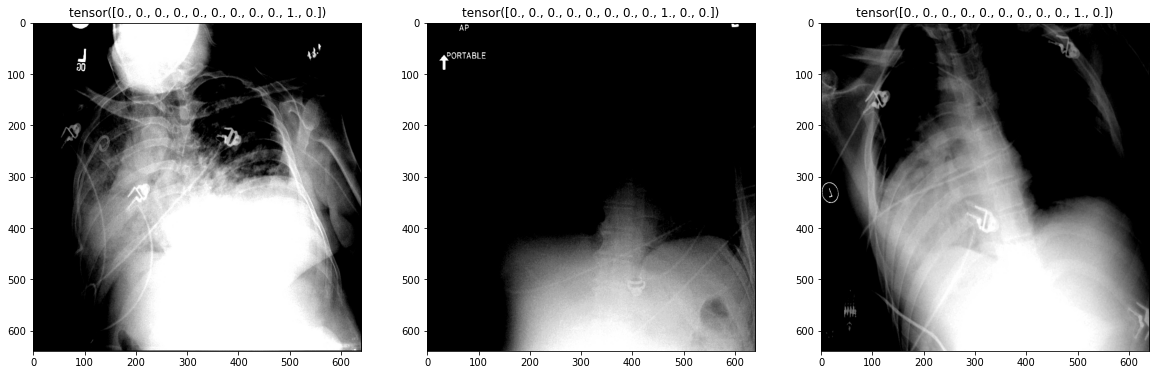

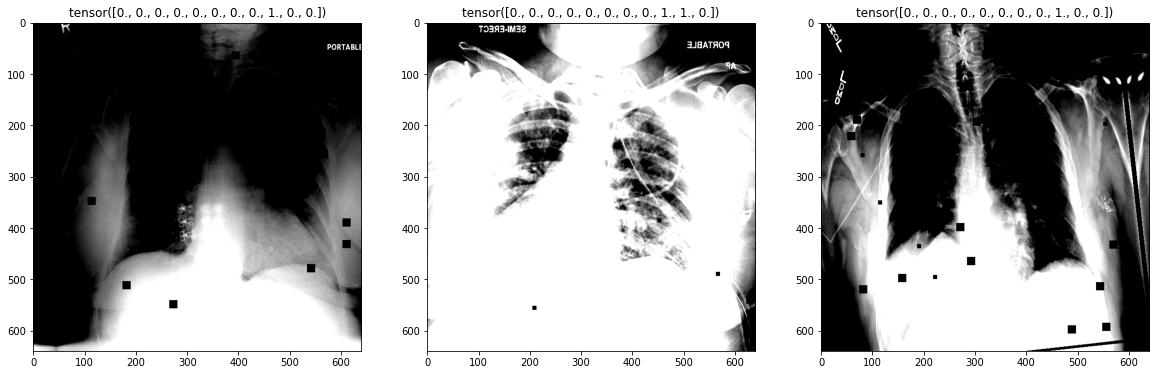

In [10]:
from pylab import rcParams
dataset_show = TrainDataset(train_df[train_df["StudyInstanceUID"].isin(train_annotations_df['StudyInstanceUID'].unique())].reset_index(drop=True),
               train_annotations_df,
               use_annot=True,
               transform=get_transforms(data='light_train') # None, get_transforms(data='check')
               )
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,3)
    for p in range(3):
        idx = np.random.randint(0, len(dataset_show))
        img, img_annot, label = dataset_show[idx] # img, img_annot, label
        # axarr[p].imshow(img) # transform=None
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(label))

# Model

In [11]:
class RanzcrClassifier(nn.Module):
    def __init__(self, model_arch, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)

        if 'efficientnet' in CFG.model_arch:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, CFG.n_class)
        elif "resnet" in CFG.model_arch:
            n_features = self.model.fc.in_features
            self.model.global_pool = nn.Identity()
            self.model.fc = nn.Identity()
            self.pooling = nn.AdaptiveAvgPool2d(1)
            self.fc = nn.Linear(n_features, CFG.n_class)

    def forward(self, x):
        if 'efficientnet' in CFG.model_arch:
            return self.model(x)
        elif "resnet" in CFG.model_arch:
            bs = x.size(0)
            features = self.model(x)
            pooled_features = self.pooling(features).view(bs, -1)
            output = self.fc(pooled_features)
            return features, pooled_features, output

In [12]:
def train_one_epoch(train_loader, teacher_model, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.device == 'GPU':
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    for step, (images, images_annot, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        with torch.no_grad():
            teacher_features, _, _ = teacher_model(images_annot.to(device))
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        if CFG.device == 'GPU':
            with autocast():
                features, _, y_preds = model(images)
                loss = criterion(teacher_features, features, y_preds, labels)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.accum_iter > 1:
                loss = loss / CFG.accum_iter
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.accum_iter == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        elif CFG.device == 'TPU':
            features, _, y_preds = model(images)
            loss = criterion(teacher_features, features, y_preds, labels)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.accum_iter > 1:
                loss = loss / CFG.accum_iter
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.accum_iter == 0:
                xm.optimizer_step(optimizer, barrier=True)
                optimizer.zero_grad()
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            cusprint('Epoch: [{0}][{1}/{2}] '
                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                'Grad: {grad_norm:.4f}  '
                'LR: {lr:.7f}  '
                .format(
                epoch, step, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses,
                remain=timeSince(start, float(step+1)/len(train_loader)),
                grad_norm=grad_norm,
                lr=optimizer.param_groups[0]["lr"],
                ))

    return losses.avg, optimizer.param_groups[0]["lr"]

In [13]:
def valid_one_epoch(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    trues = []
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            _, _, y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        trues.append(labels.to('cpu').numpy())
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.accum_iter > 1:
            loss = loss / CFG.accum_iter
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            cusprint('EVAL: [{0}/{1}] '
                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                .format(
                step, len(valid_loader), batch_time=batch_time,
                data_time=data_time, loss=losses,
                remain=timeSince(start, float(step+1)/len(valid_loader)),
                ))

    trues = np.concatenate(trues)
    predictions = np.concatenate(preds)
    return losses.avg, predictions, trues

# Scheduler

In [14]:
class GradualWarmupSchedulerV3(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV3, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch >= self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [15]:
class CustomLoss(nn.Module):
    def __init__(self, weights=[1, 1]):
        super(CustomLoss, self).__init__()
        self.weights = weights # 两种loss
        
    def forward(self, teacher_features, features, y_pred, labels):
        consistency_loss = nn.MSELoss()(teacher_features.view(-1), features.view(-1)) 
        cls_loss = nn.BCEWithLogitsLoss()(y_pred, labels)
        loss = self.weights[0] * consistency_loss + self.weights[1] * cls_loss
        return loss

# Training

In [16]:
def train_loop(df, fold, trn_idx, val_idx):
    loginfo(f"========== fold: {fold} training ==========")
    # ====================================================
    # loader
    # ====================================================
    train_folds = train_df.loc[trn_idx].reset_index(drop=True)
    valid_folds = train_df.loc[val_idx].reset_index(drop=True)

    train_folds = train_folds[train_folds['StudyInstanceUID'].isin(train_annotations_df['StudyInstanceUID'].unique())].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values

    train_dataset = TrainDataset(train_folds, train_annotations_df, use_annot=True, transform=get_transforms(data='light_train'))
    valid_dataset = TrainDataset(valid_folds, train_annotations_df, use_annot=False, transform=get_transforms(data='valid'))
    if CFG.device == 'GPU':
        train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, shuffle=True, num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, shuffle=False, num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    elif CFG.device == 'TPU':
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal(), shuffle=True)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=CFG.train_bs, sampler=train_sampler, drop_last=True, num_workers=CFG.num_workers)
        valid_sampler = torch.utils.data.distributed.DistributedSampler(valid_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal(), shuffle=False)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=CFG.valid_bs, sampler=valid_sampler, drop_last=False, num_workers=CFG.num_workers)

    # ====================================================
    # model & optimizer & scheduler & loss
    # ====================================================
    teacher_model = RanzcrClassifier(CFG.model_arch, pretrained=False)
    teacher_model.load_state_dict(torch.load(CFG.teacher)['model'])
    for param in teacher_model.parameters():
        param.requires_grad = False
    teacher_model.eval()
    teacher_model.to(device)

    model = RanzcrClassifier(CFG.model_arch, pretrained=True).to(device)

    # optimizer
    if CFG.optimizer == "Adam":
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            optimizer = Adam(model.parameters(), lr=CFG.lr/CFG.warmup_factor, weight_decay=CFG.weight_decay)
        else:
            optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    # scheduler
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)

    if CFG.scheduler_warmup=="GradualWarmupSchedulerV2":
        scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=CFG.warmup_epo, after_scheduler=scheduler)
    elif CFG.scheduler_warmup=="GradualWarmupSchedulerV3":
        scheduler_warmup = GradualWarmupSchedulerV3(optimizer, multiplier=10, total_epoch=CFG.warmup_epo, after_scheduler=scheduler)

    # loss
    if CFG.loss_fn == "BCEWithLogitsLoss":
        train_criterion = CustomLoss(weights=CFG.weights)
        valid_criterion = nn.BCEWithLogitsLoss()

    # ====================================================
    # loop
    # ====================================================

    valid_acc_max=0; valid_loss_min=float("inf")
    valid_acc_max_cnt=0; valid_loss_min_cnt=0;
    best_acc_epoch=0;

    for epoch in range(CFG.epochs):
        loginfo(f"***** Epoch {epoch} *****")

        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            loginfo(f"schwarmup_last_epoch:{scheduler_warmup.last_epoch}, schwarmup_lr:{scheduler_warmup.get_last_lr()[0]}")
        if CFG.scheduler=='CosineAnnealingLR':
            loginfo(f"scheduler_last_epoch:{scheduler.last_epoch}, scheduler_lr:{scheduler.get_last_lr()[0]}")
        loginfo(f"optimizer_lr:{optimizer.param_groups[0]['lr']}")
                
        start_time = time.time()
        # train
        if CFG.device == 'TPU' and CFG.nprocs == 8:
            para_train_loader = pl.ParallelLoader(train_loader, [device])
            avg_loss, cur_lr = train_one_epoch(para_train_loader.per_device_loader(device), teacher_model, model, train_criterion, optimizer, epoch, scheduler, device)
        else:
            avg_loss, cur_lr = train_one_epoch(train_loader, teacher_model, model, train_criterion, optimizer, epoch, scheduler, device)

        # valid
        if CFG.device == 'TPU' and CFG.nprocs == 8:
            para_valid_loader = pl.ParallelLoader(valid_loader, [device])
            avg_val_loss, preds, valid_labels = valid_one_epoch(para_valid_loader.per_device_loader(device), model, valid_criterion, device)
            preds = idist.all_gather(torch.tensor(preds)).to('cpu').numpy()
            valid_labels = idist.all_gather(torch.tensor(valid_labels)).to('cpu').numpy()
        else:
            avg_val_loss, preds, _ = valid_one_epoch(valid_loader, model, valid_criterion, device)

        # scoring
        score, scores = get_score(valid_labels, preds)
        elapsed = time.time() - start_time

        loginfo(f'Epoch {epoch} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        loginfo(f'Epoch {epoch} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')

        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            scheduler_warmup.step()
        elif CFG.scheduler == "ReduceLROnPlateau":
            scheduler.step(avg_val_loss)
        elif CFG.scheduler in ["CosineAnnealingLR", "CosineAnnealingWarmRestarts"]:
            scheduler.step()

        # early stopping
        if score > valid_acc_max:
            valid_acc_max = score
            valid_acc_max_cnt=0
            best_acc_epoch = epoch
        else:
            valid_acc_max_cnt+=1

        if avg_val_loss < valid_loss_min:
            valid_loss_min = avg_val_loss
            valid_loss_min_cnt=0
        else:
            valid_loss_min_cnt+=1

        if valid_acc_max_cnt >= CFG.n_early_stopping and valid_loss_min_cnt >= CFG.n_early_stopping:
            cur_best_list = [valid_acc_max, valid_loss_min, valid_acc_max_cnt, valid_loss_min_cnt, best_acc_epoch]
            if CFG.device == 'GPU':
                torch.save({'model': model.state_dict(), 'preds': preds, 'cur_best_list': cur_best_list}, outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
            elif CFG.device == 'TPU':
                xm.save({'model': model.state_dict(), 'preds': preds, 'cur_best_list': cur_best_list}, outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
            print("early_stopping")
            break

        cur_best_list = [valid_acc_max, valid_loss_min, valid_acc_max_cnt, valid_loss_min_cnt, best_acc_epoch]
        if CFG.device == 'GPU':
            torch.save({'model': model.state_dict(), 'preds': preds, 'cur_best_list': cur_best_list}, outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
        elif CFG.device == 'TPU':
            xm.save({'model': model.state_dict(), 'preds': preds, 'cur_best_list': cur_best_list}, outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')

    check_point = torch.load(outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{cur_best_list[4]}.pth')
    for c in [f'pred_{c}' for c in CFG.target_cols]:
        valid_folds[c] = np.nan
    valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']
    
    return valid_folds

In [17]:
def main():
    oof_df = pd.DataFrame()
    for fold, (trn_idx, val_idx) in enumerate(folds):
        if fold in CFG.fold_list:
            _oof_df = train_loop(train_df, fold, trn_idx, val_idx)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df)
                
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    oof_df.to_csv(outputdir+f'oof_df{CFG.suffix}.csv', index=False)

In [ ]:
if __name__ == '__main__':
    print(CFG.suffix)
    if CFG.device == 'TPU':
        def _mp_fn(rank, flags):
            torch.set_default_tensor_type('torch.FloatTensor')
            a = main()
        FLAGS = {}
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=CFG.nprocs, start_method='fork')
    elif CFG.device == 'GPU':
        main()

========== fold: 0 training ==========


1123


***** Epoch 0 *****
scheduler_last_epoch:0, scheduler_lr:0.001
optimizer_lr:0.001


Epoch: [0][0/450] Data 2.946 (2.946) Elapsed 0m 9s (remain 67m 54s) Loss: 6.5825(6.5825) Grad: 95246.1641  LR: 0.0010000  
Epoch: [0][100/450] Data 0.000 (0.029) Elapsed 0m 44s (remain 2m 34s) Loss: 5.0815(5.0770) Grad: 48272.4258  LR: 0.0010000  
Epoch: [0][200/450] Data 0.000 (0.015) Elapsed 1m 20s (remain 1m 39s) Loss: 4.4134(4.6343) Grad: 68064.4453  LR: 0.0010000  
Epoch: [0][300/450] Data 0.000 (0.010) Elapsed 1m 56s (remain 0m 57s) Loss: 2.9886(4.4289) Grad: 51527.6953  LR: 0.0010000  
Epoch: [0][400/450] Data 0.000 (0.008) Elapsed 2m 32s (remain 0m 18s) Loss: 4.5005(4.2780) Grad: 50997.6836  LR: 0.0010000  
Epoch: [0][449/450] Data 0.000 (0.007) Elapsed 2m 49s (remain 0m 0s) Loss: 4.0254(4.2759) Grad: 42992.2734  LR: 0.0010000  
EVAL: [0/189] Data 3.565 (3.565) Elapsed 0m 5s (remain 16m 39s) Loss: 0.2076(0.2076) 
EVAL: [100/189] Data 0.000 (0.208) Elapsed 0m 45s (remain 0m 39s) Loss: 0.2262(0.2298) 
EVAL: [188/189] Data 0.000 (0.198) Elapsed 1m 21s (remain 0m 0s) Loss: 0.5781(0

Epoch 0 - avg_train_loss: 4.2759  avg_val_loss: 0.2284  time: 252s
Epoch 0 - Score: 0.8413  Scores: [0.7627 0.8973 0.9728 0.8723 0.8008 0.9353 0.954  0.7076 0.6931 0.746
 0.9127]
***** Epoch 1 *****
scheduler_last_epoch:1, scheduler_lr:0.000985485437804313
optimizer_lr:0.000985485437804313


Epoch: [1][0/450] Data 2.657 (2.657) Elapsed 0m 3s (remain 23m 10s) Loss: 4.0722(4.0722) Grad: 138829.8438  LR: 0.0009855  
Epoch: [1][100/450] Data 0.000 (0.027) Elapsed 0m 39s (remain 2m 17s) Loss: 2.7395(3.9066) Grad: 95299.0078  LR: 0.0009855  
Epoch: [1][200/450] Data 0.000 (0.014) Elapsed 1m 15s (remain 1m 33s) Loss: 3.5763(3.6788) Grad: 99438.1484  LR: 0.0009855  
Epoch: [1][300/450] Data 0.000 (0.009) Elapsed 1m 51s (remain 0m 55s) Loss: 3.3292(3.6639) Grad: 134951.1875  LR: 0.0009855  
Epoch: [1][400/450] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 18s) Loss: 2.9758(3.6575) Grad: 59358.6641  LR: 0.0009855  
Epoch: [1][449/450] Data 0.000 (0.006) Elapsed 2m 44s (remain 0m 0s) Loss: 6.4479(3.6643) Grad: 96115.5234  LR: 0.0009855  
EVAL: [0/189] Data 3.519 (3.519) Elapsed 0m 3s (remain 11m 46s) Loss: 0.1716(0.1716) 
EVAL: [100/189] Data 0.000 (0.223) Elapsed 0m 45s (remain 0m 39s) Loss: 0.2364(0.2153) 


Epoch 1 - avg_train_loss: 3.6643  avg_val_loss: 0.2127  time: 246s
Epoch 1 - Score: 0.8759  Scores: [0.9018 0.9204 0.9825 0.8812 0.7357 0.9558 0.9651 0.8281 0.6956 0.805
 0.9633]


EVAL: [188/189] Data 0.000 (0.203) Elapsed 1m 21s (remain 0m 0s) Loss: 0.1758(0.2127) 


***** Epoch 2 *****
scheduler_last_epoch:2, scheduler_lr:0.0009427852848137784
optimizer_lr:0.0009427852848137784


Epoch: [2][0/450] Data 2.690 (2.690) Elapsed 0m 3s (remain 23m 26s) Loss: 2.4676(2.4676) Grad: 76883.3828  LR: 0.0009428  
Epoch: [2][100/450] Data 0.000 (0.027) Elapsed 0m 39s (remain 2m 15s) Loss: 3.6568(3.3182) Grad: 83085.3047  LR: 0.0009428  
Epoch: [2][200/450] Data 0.000 (0.014) Elapsed 1m 15s (remain 1m 33s) Loss: 4.6235(3.4497) Grad: 112306.6172  LR: 0.0009428  
Epoch: [2][300/450] Data 0.000 (0.009) Elapsed 1m 51s (remain 0m 55s) Loss: 3.8483(3.4951) Grad: 129913.1328  LR: 0.0009428  
Epoch: [2][400/450] Data 0.000 (0.007) Elapsed 2m 27s (remain 0m 18s) Loss: 4.3516(3.5142) Grad: 93692.8672  LR: 0.0009428  
Epoch: [2][449/450] Data 0.000 (0.006) Elapsed 2m 44s (remain 0m 0s) Loss: 4.1255(3.5149) Grad: 116486.4688  LR: 0.0009428  
EVAL: [0/189] Data 3.486 (3.486) Elapsed 0m 3s (remain 11m 40s) Loss: 0.1693(0.1693) 
EVAL: [100/189] Data 0.000 (0.222) Elapsed 0m 45s (remain 0m 39s) Loss: 0.2192(0.1984) 


Epoch 2 - avg_train_loss: 3.5149  avg_val_loss: 0.1973  time: 246s
Epoch 2 - Score: 0.8932  Scores: [0.9055 0.9315 0.986  0.8521 0.834  0.9196 0.9542 0.8512 0.753  0.8424
 0.9954]


EVAL: [188/189] Data 0.000 (0.203) Elapsed 1m 21s (remain 0m 0s) Loss: 0.3199(0.1973) 


***** Epoch 3 *****
scheduler_last_epoch:3, scheduler_lr:0.0008743811187114651
optimizer_lr:0.0008743811187114651


Epoch: [3][0/450] Data 2.709 (2.709) Elapsed 0m 3s (remain 23m 29s) Loss: 3.6739(3.6739) Grad: 102663.2422  LR: 0.0008744  
Epoch: [3][100/450] Data 0.000 (0.027) Elapsed 0m 39s (remain 2m 16s) Loss: 2.0326(3.3101) Grad: 72931.8438  LR: 0.0008744  


In [ ]:
# save as cpu
if CFG.device == 'TPU':
    for fold in range(CFG.fold_num):
        if fold in CFG.fold_list:
            # best score
            state = torch.load(outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{cur_best_list[4]}.pth')
            torch.save({'model': state['model'].to('cpu').state_dict(), 'preds': state['preds'], 'cur_best_list': state['cur_best_list']}, 
                    outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{cur_best_list[4]}_cpu.pth')